In [1]:
!nvidia-smi

Mon Oct 24 06:56:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
cd /content/drive/MyDrive/Eye_alert/

/content/drive/MyDrive/Eye_alert


In [41]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.6 MB/s 


In [5]:
#import 
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt 
import numpy as np
import time
from PIL import Image
from torch.autograd import Variable

In [ ]:
#Transform and load dataset
#Argument training_set by RandomResizedCrop, RandomHorizontalFlip
#Normalize data: [-1, 1]
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.1),
                                    # transforms.RandomRotation(degrees=(0, 10)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set = datasets.ImageFolder(root='./data/train', transform=transform_train)
val_set = datasets.ImageFolder(root='./data/val', transform=transform_val)

batch_size = 32
train_load = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_load = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

print('Train_set:', len(train_set))
print('Validation_set:', len(val_set))

Train_set: 1958
Validation_set: 560


In [6]:
#Transform and load dataset
#Argument training_set by RandomResizedCrop, RandomHorizontalFlip
#Normalize data: [-1, 1]
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.1),
                                    # transforms.RandomRotation(degrees=(0, 10)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

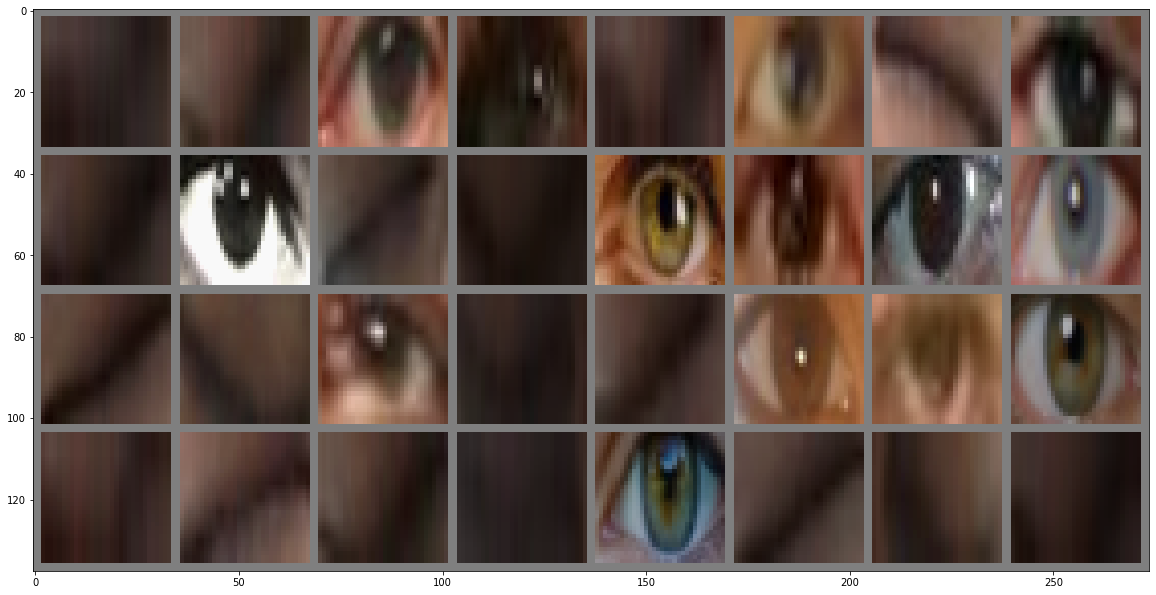

In [ ]:
#Show image in a batch
def imgshow(img):
    img = img/2 + 0.5 
    np_img = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

    
data_iter = iter(train_load)
img, labels = data_iter.next()
imgshow(torchvision.utils.make_grid(img))

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #16

        #layer 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #8

        #layer 3
        # self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # self.batchnorm5 = nn.BatchNorm2d(128)
        # self.relu = nn.ReLU()
        # self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        # self.batchnorm6 = nn.BatchNorm2d(128)
        # self.relu = nn.ReLU()
        # self.maxpool3 = nn.MaxPool2d(kernel_size=2) #4

        #FC1
        self.fc1 = nn.Linear(in_features=4096, out_features=512)
        self.batchnorm_fc1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(p=0.5)

        # self.fc2 = nn.Linear(in_features=1024, out_features=256)
        # self.batchnorm_fc2 = nn.BatchNorm1d(256)
        # self.relu = nn.ReLU()
        # self.dropout_fc2 = nn.Dropout(p=0.5)

        # self.fc3 = nn.Linear(in_features=256, out_features=64)
        # self.batchnorm_fc3 = nn.BatchNorm1d(64)
        # self.relu = nn.ReLU()
        # self.dropout_fc3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(in_features=512, out_features=2)


    def forward(self, x):
        #layer 1
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        #layer 2
        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        #layer 3
        # out = self.conv4(out)
        # out = self.batchnorm4(out)
        # out = self.relu(out)
        # out = self.conv5(out)
        # out = self.batchnorm5(out)
        # out = self.relu(out)
        # out = self.maxpool3(out)
        
        #Flatten()
        out = out.view(-1, 4096)

        #FC 1
        out = self.fc1(out)
        out = self.batchnorm_fc1(out)
        out = self.relu(out)
        out = self.dropout_fc1(out)

        #FC 2
        # out = self.fc2(out)
        # out = self.batchnorm_fc2(out)
        # out = self.relu(out)
        # out = self.dropout_fc2(out)

        # #FC 3
        # out = self.fc3(out)
        # out = self.batchnorm_fc3(out)
        # out = self.relu(out)
        # out = self.dropout_fc3(out)

        #Out
        out = self.fc4(out)

        return out

In [8]:
model = CNN()
model = model.cuda()

#Sumary model
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (batchnorm_fc1): BatchNorm1d(512, eps=1e-05,

In [15]:
#Using CrossEntropyLoss, optim  use SGD or Adam
loss_f = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.00001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Encoder label
label2id = {
    0: 'Close',
    1: 'Open',
}

In [ ]:
epochs = 12

# Training
for epoch in range(epochs): 
    
    start = time.time()
    
    #Define
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train() #set model on traning mode             
    
    for i, (inputs, labels) in enumerate(train_load, 0):
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        #Convert to Cuda() to use GPU
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()      
        
        #Forward
        outputs = model(inputs)    
        
        #Calculating loss
        loss = loss_f(outputs, labels)  
        iter_loss += loss.item()    
        
        #Backpropagation
        loss.backward()               
        optimizer.step()                
        
        # Record the correct predictions for training data 
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum()
        iterations += 1
    

    train_loss.append(iter_loss/iterations)
    train_acc.append((100 * correct / len(train_set)))
   
    #Eval on validation set
    #Define
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval() #set model on evaluation mode
    
    for i, (inputs, labels) in enumerate(val_load, 0):
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        #To Cuda
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        #Forward and Caculating loss
        outputs = model(inputs)     
        loss = loss_f(outputs, labels) 
        loss += loss.item()
        
        # Record the correct predictions for val data
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum()
        iterations += 1

    val_loss.append(loss/iterations)
    val_acc.append((100 * correct / len(val_set)))

    stop = time.time()
    # if(val_acc[-1])
    #Display acc, loss on training set and validation set
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f},,Time: {}s'
           .format(epoch+1, epochs, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1],stop-start))

Epoch 1/12, Training Loss: 0.106, Training Accuracy: 97.038, Val Loss: 0.000, Val Accuracy: 64.464,,Time: 846.1217639446259s
Epoch 2/12, Training Loss: 0.048, Training Accuracy: 98.570, Val Loss: 0.002, Val Accuracy: 99.464,,Time: 4.649125576019287s
Epoch 3/12, Training Loss: 0.032, Training Accuracy: 99.285, Val Loss: 0.002, Val Accuracy: 99.464,,Time: 4.695134401321411s
Epoch 4/12, Training Loss: 0.026, Training Accuracy: 99.489, Val Loss: 0.000, Val Accuracy: 99.821,,Time: 4.728639125823975s
Epoch 5/12, Training Loss: 0.022, Training Accuracy: 99.132, Val Loss: 0.001, Val Accuracy: 99.464,,Time: 4.665008544921875s
Epoch 6/12, Training Loss: 0.016, Training Accuracy: 99.540, Val Loss: 0.000, Val Accuracy: 99.643,,Time: 4.6431565284729s
Epoch 7/12, Training Loss: 0.017, Training Accuracy: 99.540, Val Loss: 0.013, Val Accuracy: 57.500,,Time: 4.567249774932861s
Epoch 8/12, Training Loss: 0.013, Training Accuracy: 99.642, Val Loss: 0.000, Val Accuracy: 99.643,,Time: 4.631937265396118s
Ep

In [ ]:
torch.save(model.state_dict(),'best_model.pth')

In [30]:
#Load model
model.load_state_dict(torch.load('best_model.pth'))
model.to('cuda')
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (batchnorm_fc1): BatchNorm1d(512, eps=1e-05,

In [3]:
from google.colab.output import eval_js
from IPython.display import display, Javascript, Image

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [51]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh

def plot_landmark(img_base, facial_area_obj):
    all_lm = []
    img = img_base.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    landmarks = results.multi_face_landmarks[0]
    for source_idx, target_idx in facial_area_obj:
        source = landmarks.landmark[source_idx]
        target = landmarks.landmark[target_idx]

        relative_source = (int(img.shape[1] * source.x), int(img.shape[0] * source.y))
        relative_target = (int(img.shape[1] * target.x), int(img.shape[0] * target.y))
        all_lm.append(relative_source)
        all_lm.append(relative_target)
    
    all_lm = sorted(all_lm, key = lambda a: (a[0]))
    x_min, x_max = all_lm[0][0], all_lm[-1][0]
    all_lm = sorted(all_lm, key = lambda a: (a[1]))
    y_min, y_max =  all_lm[0][1], all_lm[-1][1]
    
    img_ = img[y_min:y_max+1,x_min:x_max+1]
    return img_, [(x_min, y_min), (x_max,y_max)]

In [58]:
def predict(img, model):
    img = transform_val(img)    
    img = torch.unsqueeze(img, 0).to('cuda').float()    

    with torch.no_grad():
        output = model(img)
    
    output = F.softmax(output, dim = -1)
    predicted = torch.argmax(output)
    p = label2id[predicted.item()]
    prob = torch.max(output).item()
    
    return  p, round(prob,2)

In [69]:
import PIL
import io
from base64 import b64decode, b64encode
import cv2
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    # convert JS response to OpenCV Image
    image = js_to_image(js_reply["img"])

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if(results.multi_face_landmarks):
      # print(int(image.shape[1]/2), int(image.shape[0])-30)
      l_eyebrow, coor1 = plot_landmark(image, mp_face_mesh.FACEMESH_LEFT_EYE)
      # img = Image.fromarray(l_eyebrow)
      # pred, prob = predict(img, model)
      # pred = str(pred) + '|' + str(prob)
      # cv2.putText(bbox_array, str(pred), (coor1[0][0], coor1[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1, cv2.LINE_AA)
      cv2.rectangle(bbox_array, coor1[0], coor1[1], (255,0,0), 1)


      r_eyebrow, coor2 = plot_landmark(image, mp_face_mesh.FACEMESH_RIGHT_EYE)
      # img = Image.fromarray(r_eyebrow)
      # pred, prob = predict(img, model)
      # pred = str(pred) + '|' + str(prob)
      # cv2.putText(bbox_array, str(pred), (coor2[0][0], coor2[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1, cv2.LINE_AA)
      cv2.rectangle(bbox_array, coor2[0], coor2[1], (255,0,0), 1)

    # bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [36]:
import torch.nn.functional as F

def predict(img, model):
    img = Image.open(img)     
    
    img = transform_val(img)    
    print(img.shape)
    img = torch.unsqueeze(img, 0).to('cuda').float()    

    with torch.no_grad():
        output = model(img)
    
    output = F.softmax(output, dim = -1)
    predicted = torch.argmax(output)
    p = label2id[predicted.item()]
    prob = torch.max(output).item()
    
    return  p, round(prob,2)

In [37]:
print(predict('acv12.png', model))

torch.Size([3, 32, 32])
('Open', 1.0)
